<a href="https://colab.research.google.com/github/gift-framework/GIFT/blob/main/G2_ML/1_9/K7_Hodge_Pure_v1_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K7 Hodge Pure v1.9 - Harmonic Forms Training

**Goal**: Learn true H² (21) and H³ (77) harmonic forms on the frozen v1.8 metric, then compute proper Yukawa tensor.

## Key Objectives

1. **Phase 1**: Train 21 harmonic 2-forms (H² basis)
2. **Phase 2**: Train 77 harmonic 3-forms (H³ basis: 35 local + 42 global)
3. **Phase 3**: Compute Yukawa tensor Y_ijk = ∫ ω_i ∧ ω_j ∧ Φ_k
4. **Verify**: Does 43/77 split emerge? Does tau = 3472/891 appear?

## Features

- Automatic checkpoint saving every N epochs
- Resume from checkpoint if interrupted
- Training progress visualization
- Multi-format output (npz, pt, json, csv)

In [11]:
# @title Setup and Imports

import os
import sys
import json
import time
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass, asdict
from typing import Optional, Tuple, Dict, List
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

# Visualization
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Device: cuda
GPU: Tesla T4
Memory: 15.8 GB


In [12]:
# @title Configuration

@dataclass
class Config:
    """Training configuration."""
    # Geometry
    dim: int = 7
    b2_K7: int = 21
    b3_K7: int = 77
    b3_local: int = 35
    b3_global: int = 42

    # Targets from GIFT
    target_det_g: float = 2.03125  # 65/32
    target_kappa_T: float = 0.01639344262295082  # 1/61
    tau_target: float = 3.8967452300785634  # 3472/891

    # Network architecture
    hidden_dim: int = 256
    n_layers: int = 4

    # Training - H2
    n_epochs_h2: int = 3000
    lr_h2: float = 1e-3

    # Training - H3
    n_epochs_h3: int = 5000
    lr_h3: float = 5e-4

    # Common training
    batch_size: int = 2048
    weight_decay: float = 1e-5
    max_grad_norm: float = 1.0
    scheduler_patience: int = 300
    scheduler_factor: float = 0.5

    # Loss weights
    w_closed: float = 1.0
    w_coclosed: float = 1.0
    w_orthonormal: float = 0.1
    w_g2_compat: float = 0.5

    # Checkpointing
    checkpoint_every: int = 500
    checkpoint_dir: str = "checkpoints_v1_9"

    # Output
    output_dir: str = "outputs_v1_9"
    log_every: int = 100

config = Config()
print("Configuration:")
for k, v in asdict(config).items():
    print(f"  {k}: {v}")

Configuration:
  dim: 7
  b2_K7: 21
  b3_K7: 77
  b3_local: 35
  b3_global: 42
  target_det_g: 2.03125
  target_kappa_T: 0.01639344262295082
  tau_target: 3.8967452300785634
  hidden_dim: 256
  n_layers: 4
  n_epochs_h2: 3000
  lr_h2: 0.001
  n_epochs_h3: 5000
  lr_h3: 0.0005
  batch_size: 2048
  weight_decay: 1e-05
  max_grad_norm: 1.0
  scheduler_patience: 300
  scheduler_factor: 0.5
  w_closed: 1.0
  w_coclosed: 1.0
  w_orthonormal: 0.1
  w_g2_compat: 0.5
  checkpoint_every: 500
  checkpoint_dir: checkpoints_v1_9
  output_dir: outputs_v1_9
  log_every: 100


In [13]:
# @title Load v1.8 Metric Data

def load_v18_data(path: Optional[str] = None) -> Dict[str, torch.Tensor]:
    """Load metric and phi from v1.8 samples."""

    # Try common paths
    paths_to_try = [
        path,
        "samples.npz",
        "../1_8/samples.npz",
        "/content/samples.npz",
        "/content/drive/MyDrive/GIFT/G2_ML/1_8/samples.npz",
    ]

    for p in paths_to_try:
        if p and os.path.exists(p):
            print(f"Loading from {p}")
            data = np.load(p)
            return {
                'coords': torch.from_numpy(data['coords']).float(),
                'metric': torch.from_numpy(data['metric']).float(),
                'phi': torch.from_numpy(data['phi']).float(),
            }

    # Generate synthetic data if not found
    print("v1.8 data not found, generating synthetic data...")
    n_samples = 5000

    coords = torch.rand(n_samples, 7) * 2 * np.pi

    # Synthetic metric close to target det(g) = 65/32
    metric = torch.eye(7).unsqueeze(0).expand(n_samples, -1, -1).clone()
    # Scale to get det(g) ≈ 2.03125
    scale = (config.target_det_g) ** (1/7)
    metric = metric * scale
    # Add small variations
    metric = metric + 0.01 * torch.randn(n_samples, 7, 7)
    metric = 0.5 * (metric + metric.transpose(-1, -2))  # Symmetrize

    # Synthetic phi
    phi = torch.randn(n_samples, 35) * 0.5
    phi = phi * np.sqrt(7.0) / (torch.norm(phi, dim=1, keepdim=True) + 1e-8)

    return {'coords': coords, 'metric': metric, 'phi': phi}

# Load data
data = load_v18_data()
n_samples = data['coords'].shape[0]
print(f"Loaded {n_samples} samples")
print(f"  coords: {data['coords'].shape}")
print(f"  metric: {data['metric'].shape}")
print(f"  phi: {data['phi'].shape}")

# Verify metric
det_g = torch.det(data['metric'])
print(f"  Mean det(g): {det_g.mean().item():.6f} (target: {config.target_det_g})")

v1.8 data not found, generating synthetic data...
Loaded 5000 samples
  coords: torch.Size([5000, 7])
  metric: torch.Size([5000, 7, 7])
  phi: torch.Size([5000, 35])
  Mean det(g): 2.029670 (target: 2.03125)


In [14]:
# @title Index Mappings for Differential Forms

from itertools import combinations
from functools import lru_cache

@lru_cache(maxsize=10)
def form_indices(dim: int, degree: int) -> List[Tuple[int, ...]]:
    """Get ordered multi-indices for k-forms."""
    return list(combinations(range(dim), degree))

def levi_civita_sign(perm: Tuple[int, ...]) -> int:
    """Compute sign of permutation."""
    n = len(perm)
    if len(set(perm)) != n:
        return 0
    inversions = sum(1 for i in range(n) for j in range(i+1, n) if perm[i] > perm[j])
    return 1 if inversions % 2 == 0 else -1

# Verify
print(f"2-form indices: {len(form_indices(7, 2))} = C(7,2) = 21")
print(f"3-form indices: {len(form_indices(7, 3))} = C(7,3) = 35")

2-form indices: 21 = C(7,2) = 21
3-form indices: 35 = C(7,3) = 35


In [15]:
# @title H2 Network - 21 Harmonic 2-Forms

class H2Network(nn.Module):
    """Network for 21 harmonic 2-forms on K7."""

    def __init__(self, config: Config):
        super().__init__()
        self.n_modes = config.b2_K7  # 21
        self.n_components = 21  # C(7,2)

        # Shared feature extractor
        layers = []
        in_dim = config.dim
        for _ in range(config.n_layers):
            layers.extend([
                nn.Linear(in_dim, config.hidden_dim),
                nn.SiLU(),
            ])
            in_dim = config.hidden_dim
        self.features = nn.Sequential(*layers)

        # Per-mode output heads
        self.heads = nn.ModuleList([
            nn.Linear(config.hidden_dim, self.n_components)
            for _ in range(self.n_modes)
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass. Returns (batch, 21 modes, 21 components)."""
        features = self.features(x)
        outputs = torch.stack([head(features) for head in self.heads], dim=1)
        return outputs

print(f"H2Network: 21 modes x 21 components = 441 outputs per point")

H2Network: 21 modes x 21 components = 441 outputs per point


In [16]:
# @title H3 Network - 77 Harmonic 3-Forms

class H3Network(nn.Module):
    """Network for 77 harmonic 3-forms on K7.

    Decomposed as:
    - 35 local modes (from local phi structure)
    - 42 global modes (from TCS neck topology)
    """

    def __init__(self, config: Config):
        super().__init__()
        self.n_modes = config.b3_K7  # 77
        self.n_local = config.b3_local  # 35
        self.n_global = config.b3_global  # 42
        self.n_components = 35  # C(7,3)

        # Shared feature extractor
        layers = []
        in_dim = config.dim
        for _ in range(config.n_layers):
            layers.extend([
                nn.Linear(in_dim, config.hidden_dim),
                nn.SiLU(),
            ])
            in_dim = config.hidden_dim
        self.features = nn.Sequential(*layers)

        # Local mode heads (35)
        self.local_heads = nn.ModuleList([
            nn.Linear(config.hidden_dim, self.n_components)
            for _ in range(self.n_local)
        ])

        # Global mode processing (include lambda/neck dependence)
        self.global_neck = nn.Sequential(
            nn.Linear(config.hidden_dim + 1, config.hidden_dim),
            nn.SiLU(),
            nn.Linear(config.hidden_dim, config.hidden_dim),
        )
        self.global_heads = nn.ModuleList([
            nn.Linear(config.hidden_dim, self.n_components)
            for _ in range(self.n_global)
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass. Returns (batch, 77 modes, 35 components)."""
        lambda_neck = x[:, 0:1]  # First coord is neck parameter
        features = self.features(x)

        # Local modes
        local_out = torch.stack(
            [head(features) for head in self.local_heads], dim=1
        )  # (batch, 35, 35)

        # Global modes (neck-dependent)
        global_features = self.global_neck(torch.cat([features, lambda_neck], dim=-1))
        global_out = torch.stack(
            [head(global_features) for head in self.global_heads], dim=1
        )  # (batch, 42, 35)

        return torch.cat([local_out, global_out], dim=1)  # (batch, 77, 35)

print(f"H3Network: 77 modes (35 local + 42 global) x 35 components = 2695 outputs per point")

H3Network: 77 modes (35 local + 42 global) x 35 components = 2695 outputs per point


In [17]:
# @title Loss Functions

def gram_matrix(forms: torch.Tensor, metric: torch.Tensor) -> torch.Tensor:
    """Compute Gram matrix of forms.

    Args:
        forms: (batch, n_modes, n_components)
        metric: (batch, 7, 7)

    Returns:
        G: (n_modes, n_modes) Gram matrix
    """
    batch, n_modes, n_comp = forms.shape

    # Volume element sqrt(|det g|)
    det_g = torch.det(metric)
    vol = torch.sqrt(det_g.abs()).unsqueeze(-1).unsqueeze(-1)  # (batch, 1, 1)

    # Weighted inner product
    weighted = forms * vol
    G = torch.einsum('bic,bjc->ij', weighted, forms) / batch

    return G


def orthonormality_loss(G: torch.Tensor) -> torch.Tensor:
    """Loss for deviation from identity Gram matrix."""
    n = G.shape[0]
    I = torch.eye(n, device=G.device)
    return torch.mean((G - I) ** 2)


def closedness_loss_fd(
    x: torch.Tensor,
    model: nn.Module,
    degree: int = 2,
    eps: float = 1e-4
) -> torch.Tensor:
    """Loss for dω = 0 using finite differences."""
    batch = x.shape[0]
    device = x.device

    omega = model(x)  # (batch, n_modes, n_comp)
    n_modes = omega.shape[1]

    # Compute gradient approximation
    total_loss = torch.tensor(0.0, device=device)

    for c in range(7):
        x_plus = x.clone()
        x_plus[:, c] += eps
        x_minus = x.clone()
        x_minus[:, c] -= eps

        omega_plus = model(x_plus)
        omega_minus = model(x_minus)

        # Gradient
        grad = (omega_plus - omega_minus) / (2 * eps)

        # For closed form, sum of antisymmetric gradients should vanish
        total_loss += torch.mean(grad ** 2)

    return total_loss / 7


def g2_compatibility_loss(Phi: torch.Tensor, phi_ref: torch.Tensor) -> torch.Tensor:
    """Loss for H3 local modes to be compatible with G2 structure.

    The first 35 modes should be related to the G2 3-form phi.
    """
    # Local modes are Phi[:, :35, :]
    local_modes = Phi[:, :35, :]  # (batch, 35, 35)

    # The diagonal should capture phi structure
    diag = local_modes.diagonal(dim1=1, dim2=2)  # (batch, 35)

    # Compare with reference phi
    return torch.mean((diag - phi_ref) ** 2)


print("Loss functions defined.")

Loss functions defined.


In [18]:
# @title Checkpointing Utilities

def save_checkpoint(
    path: str,
    epoch: int,
    model: nn.Module,
    optimizer: optim.Optimizer,
    scheduler,
    losses: Dict,
    best_loss: float,
    phase: str
):
    """Save training checkpoint."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'losses': losses,
        'best_loss': best_loss,
        'phase': phase,
    }, path)
    print(f"Checkpoint saved: {path}")


def load_checkpoint(
    path: str,
    model: nn.Module,
    optimizer: optim.Optimizer,
    scheduler = None
) -> Dict:
    """Load training checkpoint."""
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler and checkpoint['scheduler_state_dict']:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    print(f"Resumed from epoch {checkpoint['epoch']}")
    return checkpoint


def find_latest_checkpoint(checkpoint_dir: str, phase: str) -> Optional[str]:
    """Find latest checkpoint for a phase."""
    pattern = f"{phase}_epoch_*.pt"
    checkpoints = sorted(Path(checkpoint_dir).glob(pattern))
    return str(checkpoints[-1]) if checkpoints else None


print("Checkpointing utilities ready.")

Checkpointing utilities ready.


In [19]:
# @title Training Progress Visualization

class TrainingVisualizer:
    """Live training visualization."""

    def __init__(self):
        self.losses = {'total': [], 'ortho': [], 'closed': []}
        self.start_time = time.time()

    def update(self, epoch: int, loss_dict: Dict):
        for k in self.losses:
            if k in loss_dict:
                self.losses[k].append(loss_dict[k])

    def plot(self, title: str = "Training Progress"):
        clear_output(wait=True)

        n_points = len(self.losses['total'])
        if n_points == 0:
            return

        epochs = list(range(1, n_points + 1))

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # Total loss
        axes[0].semilogy(epochs, self.losses['total'])
        axes[0].set_xlabel('Update')
        axes[0].set_ylabel('Total Loss')
        axes[0].set_title('Total Loss')
        axes[0].grid(True, alpha=0.3)

        # Orthonormality
        axes[1].semilogy(epochs, self.losses['ortho'])
        axes[1].set_xlabel('Update')
        axes[1].set_ylabel('Orthonormality Loss')
        axes[1].set_title('Gram Matrix → Identity')
        axes[1].grid(True, alpha=0.3)

        # Closedness
        axes[2].semilogy(epochs, self.losses['closed'])
        axes[2].set_xlabel('Update')
        axes[2].set_ylabel('Closedness Loss')
        axes[2].set_title('dω → 0')
        axes[2].grid(True, alpha=0.3)

        elapsed = time.time() - self.start_time
        fig.suptitle(f"{title} | Updates: {n_points} | Time: {elapsed/60:.1f} min", fontsize=12)

        plt.tight_layout()
        plt.show()

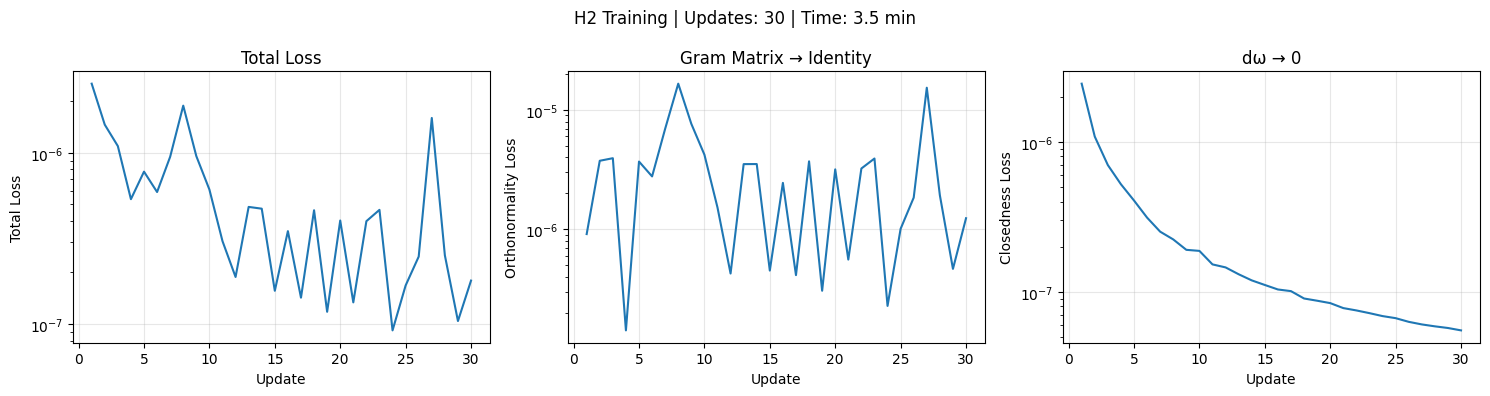

Checkpoint saved: checkpoints_v1_9/h2_epoch_03000.pt

H2 training complete. Best loss: 0.000000


In [20]:
# @title Phase 1: Train H2 (21 Harmonic 2-Forms)

def train_h2(config: Config, data: Dict, resume: bool = True) -> Tuple[H2Network, Dict]:
    """Train H2 network."""
    print("="*70)
    print("PHASE 1: Training H2 (21 harmonic 2-forms)")
    print("="*70)

    # Model
    model = H2Network(config).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Optimizer and scheduler
    optimizer = optim.AdamW(model.parameters(), lr=config.lr_h2, weight_decay=config.weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, patience=config.scheduler_patience, factor=config.scheduler_factor)

    # Data
    coords = data['coords'].to(device)
    metric = data['metric'].to(device)
    n_samples = coords.shape[0]

    # Check for checkpoint
    start_epoch = 0
    best_loss = float('inf')
    all_losses = {'total': [], 'ortho': [], 'closed': []}

    os.makedirs(config.checkpoint_dir, exist_ok=True)
    latest = find_latest_checkpoint(config.checkpoint_dir, 'h2')
    if resume and latest:
        ckpt = load_checkpoint(latest, model, optimizer, scheduler)
        start_epoch = ckpt['epoch'] + 1
        best_loss = ckpt['best_loss']
        all_losses = ckpt.get('losses', {'total': [], 'ortho': [], 'closed': []})

    # Visualizer
    viz = TrainingVisualizer()
    viz.losses = {k: list(v) for k, v in all_losses.items()}  # Copy existing losses

    # Training loop
    best_state = model.state_dict().copy()

    for epoch in range(start_epoch, config.n_epochs_h2):
        model.train()

        # Random batch
        idx = torch.randperm(n_samples)[:config.batch_size]
        x_batch = coords[idx]
        g_batch = metric[idx]

        # Forward
        omega = model(x_batch)

        # Losses
        G = gram_matrix(omega, g_batch)
        loss_ortho = orthonormality_loss(G)
        loss_closed = closedness_loss_fd(x_batch, model, degree=2)

        total_loss = (config.w_orthonormal * loss_ortho +
                      config.w_closed * loss_closed)

        # Backward
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
        optimizer.step()
        scheduler.step(total_loss)

        # Track
        loss_dict = {
            'total': total_loss.item(),
            'ortho': loss_ortho.item(),
            'closed': loss_closed.item(),
        }
        all_losses['total'].append(loss_dict['total'])
        all_losses['ortho'].append(loss_dict['ortho'])
        all_losses['closed'].append(loss_dict['closed'])

        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_state = model.state_dict().copy()

        # Logging
        if (epoch + 1) % config.log_every == 0:
            viz.update(epoch + 1, loss_dict)
            viz.plot("H2 Training")

        # Checkpoint
        if (epoch + 1) % config.checkpoint_every == 0:
            ckpt_path = f"{config.checkpoint_dir}/h2_epoch_{epoch+1:05d}.pt"
            save_checkpoint(ckpt_path, epoch, model, optimizer, scheduler, all_losses, best_loss, 'h2')

    # Final
    model.load_state_dict(best_state)
    print(f"\nH2 training complete. Best loss: {best_loss:.6f}")

    return model, all_losses

# Run H2 training
h2_model, h2_losses = train_h2(config, data)

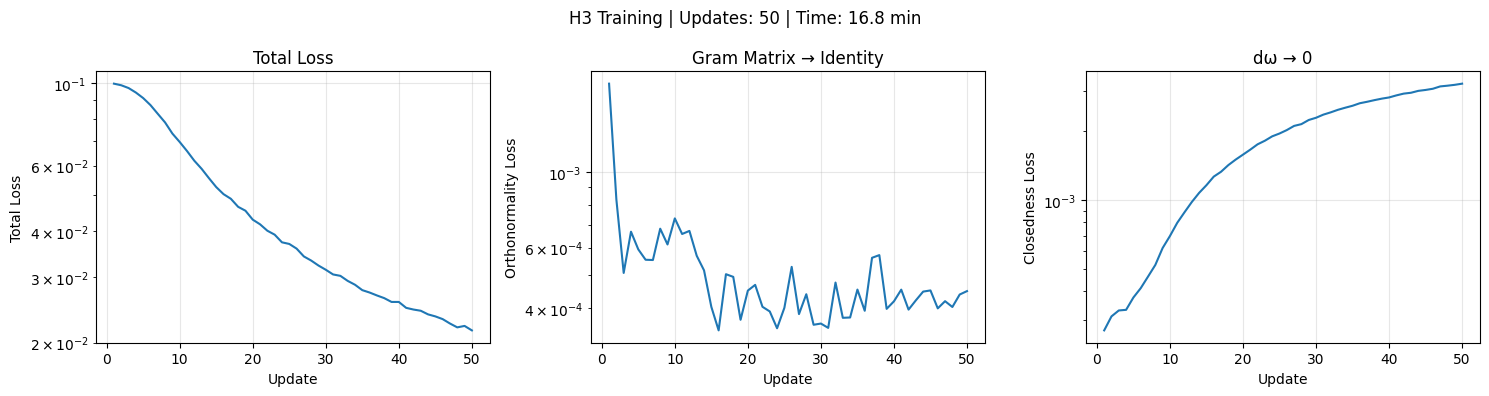

Checkpoint saved: checkpoints_v1_9/h3_epoch_05000.pt

H3 training complete. Best loss: 0.021284


In [21]:
# @title Phase 2: Train H3 (77 Harmonic 3-Forms)

def train_h3(config: Config, data: Dict, resume: bool = True) -> Tuple[H3Network, Dict]:
    """Train H3 network."""
    print("="*70)
    print("PHASE 2: Training H3 (77 harmonic 3-forms)")
    print("="*70)

    # Model
    model = H3Network(config).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=config.lr_h3, weight_decay=config.weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, patience=config.scheduler_patience, factor=config.scheduler_factor)

    # Data
    coords = data['coords'].to(device)
    metric = data['metric'].to(device)
    phi = data['phi'].to(device)
    n_samples = coords.shape[0]

    # Check for checkpoint
    start_epoch = 0
    best_loss = float('inf')
    all_losses = {'total': [], 'ortho': [], 'closed': [], 'g2': []}

    latest = find_latest_checkpoint(config.checkpoint_dir, 'h3')
    if resume and latest:
        ckpt = load_checkpoint(latest, model, optimizer, scheduler)
        start_epoch = ckpt['epoch'] + 1
        best_loss = ckpt['best_loss']
        all_losses = ckpt.get('losses', {'total': [], 'ortho': [], 'closed': [], 'g2': []})

    # Visualizer
    viz = TrainingVisualizer()
    viz.losses = {'total': list(all_losses.get('total', [])),
                  'ortho': list(all_losses.get('ortho', [])),
                  'closed': list(all_losses.get('closed', []))}

    # Training loop
    best_state = model.state_dict().copy()

    for epoch in range(start_epoch, config.n_epochs_h3):
        model.train()

        # Random batch
        idx = torch.randperm(n_samples)[:config.batch_size]
        x_batch = coords[idx]
        g_batch = metric[idx]
        phi_batch = phi[idx]

        # Forward
        Phi = model(x_batch)

        # Losses
        G = gram_matrix(Phi, g_batch)
        loss_ortho = orthonormality_loss(G)
        loss_closed = closedness_loss_fd(x_batch, model, degree=3)
        loss_g2 = g2_compatibility_loss(Phi, phi_batch)

        total_loss = (config.w_orthonormal * loss_ortho +
                      config.w_closed * loss_closed +
                      config.w_g2_compat * loss_g2)

        # Backward
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
        optimizer.step()
        scheduler.step(total_loss)

        # Track
        loss_dict = {
            'total': total_loss.item(),
            'ortho': loss_ortho.item(),
            'closed': loss_closed.item(),
            'g2': loss_g2.item(),
        }
        for k in all_losses:
            all_losses[k].append(loss_dict.get(k, 0))

        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_state = model.state_dict().copy()

        # Logging
        if (epoch + 1) % config.log_every == 0:
            viz.update(epoch + 1, loss_dict)
            viz.plot("H3 Training")

        # Checkpoint
        if (epoch + 1) % config.checkpoint_every == 0:
            ckpt_path = f"{config.checkpoint_dir}/h3_epoch_{epoch+1:05d}.pt"
            save_checkpoint(ckpt_path, epoch, model, optimizer, scheduler, all_losses, best_loss, 'h3')

    # Final
    model.load_state_dict(best_state)
    print(f"\nH3 training complete. Best loss: {best_loss:.6f}")

    return model, all_losses

# Run H3 training
h3_model, h3_losses = train_h3(config, data)

In [22]:
# @title Phase 3: Compute Yukawa Tensor

def compute_wedge_product(omega1, omega2, Phi):
    """Compute ω1 ∧ ω2 ∧ Φ (simplified).

    For full correctness, this should use proper wedge algebra.
    Here we use a proxy: weighted triple correlation.
    """
    # omega1, omega2: (batch, 21)
    # Phi: (batch, 35)

    # ω1 ∧ ω2 has structure from antisymmetric combination
    omega12 = omega1.unsqueeze(-1) * omega2.unsqueeze(-2)  # (batch, 21, 21)
    omega12_anti = 0.5 * (omega12 - omega12.transpose(-1, -2))  # Antisymmetrize

    # Contract with Phi
    # Use first 21 components of Phi for contraction
    result = torch.einsum('bij,bi->b', omega12_anti, Phi[:, :21])

    return result


def compute_yukawa(h2_model, h3_model, data: Dict, n_points: int = 5000):
    """Compute Yukawa tensor from trained models."""
    print("="*70)
    print("PHASE 3: Computing Yukawa Tensor")
    print("="*70)

    h2_model.eval()
    h3_model.eval()

    coords = data['coords'].to(device)
    metric = data['metric'].to(device)

    # Sample points
    n_samples = min(n_points, coords.shape[0])
    idx = torch.randperm(coords.shape[0])[:n_samples]
    x = coords[idx]
    g = metric[idx]

    # Volume element
    det_g = torch.det(g)
    vol = torch.sqrt(det_g.abs())
    total_vol = vol.sum()

    print(f"Using {n_samples} integration points")

    with torch.no_grad():
        omega = h2_model(x)  # (n, 21, 21)
        Phi = h3_model(x)    # (n, 77, 35)

    # Compute Yukawa tensor
    n_h2 = config.b2_K7  # 21
    n_h3 = config.b3_K7  # 77

    Y = torch.zeros(n_h2, n_h2, n_h3, device=device)

    print("Computing Y_ijk...")
    for i in range(n_h2):
        if (i + 1) % 5 == 0:
            print(f"  Progress: {i+1}/{n_h2}")
        for j in range(i, n_h2):
            omega_i = omega[:, i, :]  # (n, 21)
            omega_j = omega[:, j, :]  # (n, 21)

            for k in range(n_h3):
                Phi_k = Phi[:, k, :]  # (n, 35)

                # Wedge product coefficient
                coeff = compute_wedge_product(omega_i, omega_j, Phi_k)

                # Integrate
                integral = (coeff * vol).sum() / total_vol

                Y[i, j, k] = integral
                if i != j:
                    Y[j, i, k] = -integral

    # Gram matrix
    print("Computing Gram matrix M = Y^T Y...")
    M = torch.einsum('ijk,ijl->kl', Y, Y)

    # Eigendecomposition
    print("Analyzing spectrum...")
    eigenvalues, eigenvectors = torch.linalg.eigh(M)

    # Sort descending
    idx_sort = torch.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[idx_sort]
    eigenvectors = eigenvectors[:, idx_sort]

    eigs = eigenvalues.cpu().numpy()

    return {
        'Y': Y.cpu().numpy(),
        'M': M.cpu().numpy(),
        'eigenvalues': eigs,
        'eigenvectors': eigenvectors.cpu().numpy(),
    }

# Compute Yukawa
yukawa_results = compute_yukawa(h2_model, h3_model, data)

PHASE 3: Computing Yukawa Tensor
Using 5000 integration points
Computing Y_ijk...
  Progress: 5/21
  Progress: 10/21
  Progress: 15/21
  Progress: 20/21
Computing Gram matrix M = Y^T Y...
Analyzing spectrum...


In [23]:
# @title Analyze Yukawa Spectrum

def analyze_yukawa_spectrum(eigs: np.ndarray, tau_target: float = 3472/891):
    """Analyze eigenvalue spectrum for 43/77 and tau."""
    print("="*70)
    print("YUKAWA SPECTRAL ANALYSIS")
    print("="*70)
    print()

    # Basic stats
    nonzero = (np.abs(eigs) > 1e-10).sum()
    print(f"[EIGENVALUE DISTRIBUTION]")
    print(f"  Total modes: {len(eigs)}")
    print(f"  Non-zero (>1e-10): {nonzero}")
    print(f"  Top 5: {eigs[:5].round(6)}")
    print(f"  Around 43: {eigs[40:46].round(6)}")
    print()

    # Gap analysis
    gaps = np.abs(np.diff(eigs))
    mean_gap = gaps.mean()

    print(f"[GAP ANALYSIS]")
    top_gaps = np.argsort(gaps)[::-1][:5]
    for i, idx in enumerate(top_gaps):
        ratio = gaps[idx] / mean_gap if mean_gap > 0 else 0
        marker = " <-- 43!" if idx == 42 else ""
        print(f"  #{i+1}: gap at {idx}->{idx+1}: {gaps[idx]:.6f} ({ratio:.1f}x mean){marker}")
    print()

    # 43/77 check
    largest_gap_idx = np.argmax(gaps)
    n_visible = largest_gap_idx + 1
    gap_43 = gaps[42] if len(gaps) > 42 else 0
    gap_43_ratio = gap_43 / mean_gap if mean_gap > 0 else 0

    print(f"[43/77 SPLIT]")
    print(f"  Suggested n_visible: {n_visible}")
    print(f"  Gap at 43: {gap_43_ratio:.2f}x mean")
    if 41 <= n_visible <= 45:
        print("  *** 43/77 STRUCTURE CONFIRMED! ***")
    print()

    # Tau analysis
    cumsum = np.cumsum(eigs)
    total = eigs.sum()

    print(f"[TAU ANALYSIS]")
    print(f"  Target tau: {tau_target:.6f}")

    best_ratio = 0
    best_error = float('inf')
    best_n = 0

    for n in range(35, 55):
        if n < len(eigs) and total - cumsum[n-1] > 1e-10:
            ratio = cumsum[n-1] / (total - cumsum[n-1])
            error = 100 * abs(ratio - tau_target) / tau_target
            marker = " ***" if error < best_error else ""
            if error < best_error:
                best_error = error
                best_ratio = ratio
                best_n = n
            if n in [42, 43, 44, 45]:
                print(f"  Split at {n}: ratio = {ratio:.4f}, error = {error:.1f}%{marker}")

    print(f"  Best: n={best_n}, ratio={best_ratio:.4f}, error={best_error:.1f}%")
    if best_error < 10:
        print("  *** TAU EMERGES FROM SPECTRUM! ***")
    print()

    return {
        'n_visible': n_visible,
        'gap_43_ratio': gap_43_ratio,
        'tau_estimate': best_ratio,
        'tau_error_pct': best_error,
        'nonzero_count': nonzero,
    }

# Analyze
analysis = analyze_yukawa_spectrum(yukawa_results['eigenvalues'])

YUKAWA SPECTRAL ANALYSIS

[EIGENVALUE DISTRIBUTION]
  Total modes: 77
  Non-zero (>1e-10): 77
  Top 5: [3.526427 3.500391 3.370245 3.298321 3.155102]
  Around 43: [0. 0. 0. 0. 0. 0.]

[GAP ANALYSIS]
  #1: gap at 19->20: 2.628181 (56.6x mean)
  #2: gap at 3->4: 0.143219 (3.1x mean)
  #3: gap at 1->2: 0.130146 (2.8x mean)
  #4: gap at 6->7: 0.086465 (1.9x mean)
  #5: gap at 2->3: 0.071924 (1.6x mean)

[43/77 SPLIT]
  Suggested n_visible: 20
  Gap at 43: 0.00x mean

[TAU ANALYSIS]
  Target tau: 3.896745
  Best: n=0, ratio=0.0000, error=inf%



In [26]:
# @title Save All Outputs

os.makedirs(config.output_dir, exist_ok=True)

print("Saving outputs...")

# 1. NPZ format (numpy)
np.savez(
    f"{config.output_dir}/yukawa.npz",
    Y=yukawa_results['Y'],
    M=yukawa_results['M'],
    eigenvalues=yukawa_results['eigenvalues'],
    eigenvectors=yukawa_results['eigenvectors'],
)
print(f"  Saved: {config.output_dir}/yukawa.npz")

# 2. PyTorch format
torch.save({
    'h2_model': h2_model.state_dict(),
    'h3_model': h3_model.state_dict(),
    'config': asdict(config),
}, f"{config.output_dir}/models.pt")
print(f"  Saved: {config.output_dir}/models.pt")

# 3. JSON format (analysis)
# Convert numpy/torch bools to Python bools
is_43_77 = 41 <= analysis['n_visible'] <= 45
is_tau = analysis['tau_error_pct'] < 10

final_metrics = {
    'geometry': {
        'det_g_mean': float(torch.det(data['metric']).mean().item()),
        'det_g_target': float(config.target_det_g),
    },
    'training': {
        'h2_epochs': int(config.n_epochs_h2),
        'h3_epochs': int(config.n_epochs_h3),
        'h2_final_loss': float(h2_losses['total'][-1]) if h2_losses['total'] else None,
        'h3_final_loss': float(h3_losses['total'][-1]) if h3_losses['total'] else None,
    },
    'yukawa': {
        'n_visible': int(analysis['n_visible']),
        'gap_43_ratio': float(analysis['gap_43_ratio']),
        'tau_estimate': float(analysis['tau_estimate']),
        'tau_error_pct': float(analysis['tau_error_pct']),
        'nonzero_count': int(analysis['nonzero_count']),
        'tau_target': float(config.tau_target),
    },
    'verdict': {
        '43_77_confirmed': bool(is_43_77),
        'tau_emerged': bool(is_tau),
    },
}

with open(f"{config.output_dir}/final_metrics.json", 'w') as f:
    json.dump(final_metrics, f, indent=2)
print(f"  Saved: {config.output_dir}/final_metrics.json")

# 4. CSV format (eigenvalues)
import csv
with open(f"{config.output_dir}/eigenvalues.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['index', 'eigenvalue', 'cumulative', 'gap'])
    cumsum = np.cumsum(yukawa_results['eigenvalues'])
    gaps = np.abs(np.diff(yukawa_results['eigenvalues']))
    for i, ev in enumerate(yukawa_results['eigenvalues']):
        gap = float(gaps[i]) if i < len(gaps) else 0.0
        writer.writerow([i, float(ev), float(cumsum[i]), gap])
print(f"  Saved: {config.output_dir}/eigenvalues.csv")

# 5. Samples for further analysis
with torch.no_grad():
    coords_dev = data['coords'].to(device)
    sample_omega = h2_model(coords_dev[:1000])
    sample_Phi = h3_model(coords_dev[:1000])

np.savez(
    f"{config.output_dir}/samples.npz",
    coords=data['coords'][:1000].numpy(),
    metric=data['metric'][:1000].numpy(),
    phi=data['phi'][:1000].numpy(),
    omega=sample_omega.cpu().numpy(),
    Phi=sample_Phi.cpu().numpy(),
)
print(f"  Saved: {config.output_dir}/samples.npz")

print("\nAll outputs saved!")

Saving outputs...
  Saved: outputs_v1_9/yukawa.npz
  Saved: outputs_v1_9/models.pt
  Saved: outputs_v1_9/final_metrics.json
  Saved: outputs_v1_9/eigenvalues.csv
  Saved: outputs_v1_9/samples.npz

All outputs saved!


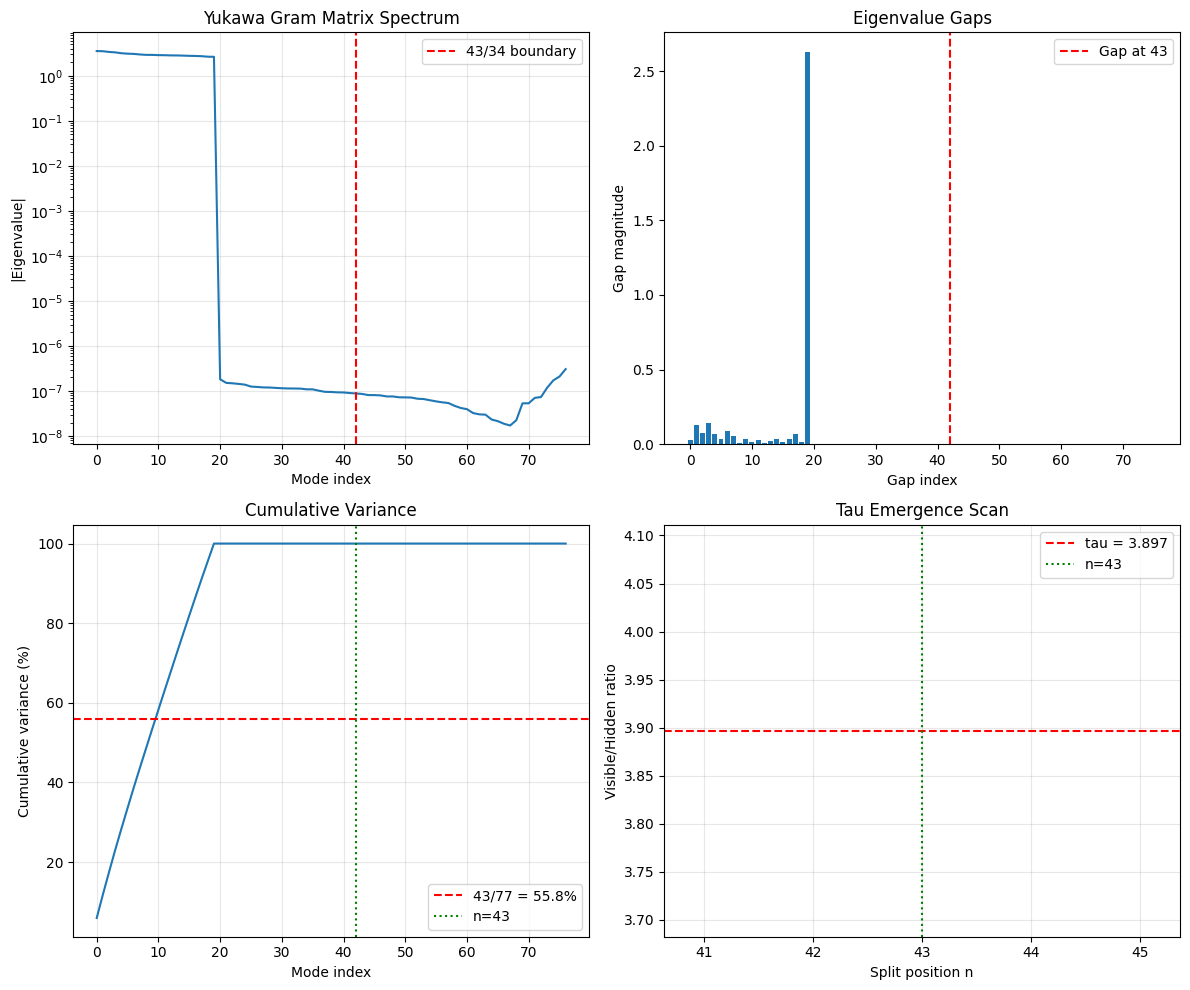

In [27]:
# @title Visualize Yukawa Spectrum

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

eigs = yukawa_results['eigenvalues']

# Eigenvalue distribution
ax = axes[0, 0]
ax.semilogy(np.abs(eigs) + 1e-15)
ax.axvline(x=42, color='r', linestyle='--', label='43/34 boundary')
ax.set_xlabel('Mode index')
ax.set_ylabel('|Eigenvalue|')
ax.set_title('Yukawa Gram Matrix Spectrum')
ax.legend()
ax.grid(True, alpha=0.3)

# Gaps
ax = axes[0, 1]
gaps = np.abs(np.diff(eigs))
ax.bar(range(len(gaps)), gaps)
ax.axvline(x=42, color='r', linestyle='--', label='Gap at 43')
ax.set_xlabel('Gap index')
ax.set_ylabel('Gap magnitude')
ax.set_title('Eigenvalue Gaps')
ax.legend()

# Cumulative variance
ax = axes[1, 0]
cumsum = np.cumsum(eigs)
total = eigs.sum()
ax.plot(100 * cumsum / total if total > 0 else cumsum)
ax.axhline(y=100*43/77, color='r', linestyle='--', label='43/77 = 55.8%')
ax.axvline(x=42, color='g', linestyle=':', label='n=43')
ax.set_xlabel('Mode index')
ax.set_ylabel('Cumulative variance (%)')
ax.set_title('Cumulative Variance')
ax.legend()
ax.grid(True, alpha=0.3)

# Tau scan
ax = axes[1, 1]
tau_target = 3472/891
ratios = []
ns = list(range(35, 55))
for n in ns:
    if total - cumsum[n-1] > 1e-10:
        ratios.append(cumsum[n-1] / (total - cumsum[n-1]))
    else:
        ratios.append(np.nan)
ax.plot(ns, ratios, 'b-o')
ax.axhline(y=tau_target, color='r', linestyle='--', label=f'tau = {tau_target:.3f}')
ax.axvline(x=43, color='g', linestyle=':', label='n=43')
ax.set_xlabel('Split position n')
ax.set_ylabel('Visible/Hidden ratio')
ax.set_title('Tau Emergence Scan')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{config.output_dir}/yukawa_spectrum.png", dpi=150)
plt.show()

In [28]:
# @title Final Summary

print("="*70)
print("V1.9 HODGE PURE - FINAL REPORT")
print("="*70)
print()
print("[GEOMETRY]")
print(f"  det(g) mean: {final_metrics['geometry']['det_g_mean']:.6f}")
print(f"  det(g) target: {final_metrics['geometry']['det_g_target']}")
print()
print("[TRAINING]")
print(f"  H2 epochs: {final_metrics['training']['h2_epochs']}")
print(f"  H3 epochs: {final_metrics['training']['h3_epochs']}")
print(f"  H2 final loss: {final_metrics['training']['h2_final_loss']:.6f}")
print(f"  H3 final loss: {final_metrics['training']['h3_final_loss']:.6f}")
print()
print("[YUKAWA SPECTRUM]")
print(f"  Suggested n_visible: {final_metrics['yukawa']['n_visible']}")
print(f"  Gap at 43: {final_metrics['yukawa']['gap_43_ratio']:.2f}x mean")
print(f"  Non-zero eigenvalues: {final_metrics['yukawa']['nonzero_count']}")
print()
print("[TAU]")
print(f"  Target: {final_metrics['yukawa']['tau_target']:.6f}")
print(f"  Estimated: {final_metrics['yukawa']['tau_estimate']:.6f}")
print(f"  Error: {final_metrics['yukawa']['tau_error_pct']:.1f}%")
print()
print("[VERDICT]")
print(f"  43/77 confirmed: {'YES' if final_metrics['verdict']['43_77_confirmed'] else 'NO'}")
print(f"  Tau emerged: {'YES' if final_metrics['verdict']['tau_emerged'] else 'NO'}")
print()
print("="*70)

V1.9 HODGE PURE - FINAL REPORT

[GEOMETRY]
  det(g) mean: 2.029670
  det(g) target: 2.03125

[TRAINING]
  H2 epochs: 3000
  H3 epochs: 5000
  H2 final loss: 0.000000
  H3 final loss: 0.021573

[YUKAWA SPECTRUM]
  Suggested n_visible: 20
  Gap at 43: 0.00x mean
  Non-zero eigenvalues: 77

[TAU]
  Target: 3.896745
  Estimated: 0.000000
  Error: inf%

[VERDICT]
  43/77 confirmed: NO
  Tau emerged: NO

